# Assignment 2

## Question 1 [15 Pts]:

Suppose data $\{x_i\}_{i = 1}^{i = n}$ is drawn from a normal distribution of _known_ standard deviation $\sigma$ and _unknown_ mean $\mu$
- Derive the MLE estimate $\mu_{\text{MLE}}$
- Derive the MAP estimate $\mu_{\text{MAP}}$ assuming the prior is also a normal distribution with mean $\tau$ and standard deviation $\omega$. What happens as $n \rightarrow \infty$?


## Answer: MLE Estimate



### Deriving (log) loss function

$\theta _{MLE}=\arg \max L\left(\theta \mid D\right)=\arg \max p\left(D\mid \theta \right)$

$\mu _{MLE}=\arg\max p\left(x_1, ..., x_n \mid \mu ,\sigma \right)$ where $\sigma$ is already known

Given the i.i.d. assumption:

$\mu _{MLE}=\arg \max \prod _{i=1}^np\left(x_i\mid \mu ,\sigma \right)$

We then log the argmax term to obtain the loss function:

$L(\mu)=\log \left(\prod _{i=1}^np\left(x_i\mid \mu ,\sigma \right)\right)=\sum _{i=1}^n\log \left(p\left(x_i\mid \mu ,\sigma \right)\right)$

### Solving loss function

We solve for each individual term in the loss function L:

$\log \left(p\left(x_i\mid \mu ,\sigma \right)\right)=\log \left(\frac{1}{\sqrt{2\pi \sigma ^2}}e^{\frac{\left(x_i-\mu \right)^2}{2\sigma ^2}}\right)=-\frac{1}{2}\log \left(2\pi \right)-\log \left(\sigma \right)-\frac{\left(x_i-\mu \right)^2}{2\sigma ^2}$

We thus find that the loss function can be rewritten as:

$L(\mu )=-\frac{n}{2}\log \left(2\pi \right)-n\log \left(\sigma \right)-\sum _{i=1}^n\frac{\left(x_i-\mu \right)^2}{2\sigma ^2}$

### Solving for critical points of loss

We set the derivative of the loss equal to zero, and solve as follows:

$\frac{dL(\mu )}{d\mu }=0+0+\sum _{i=1}^n\frac{\left(x_i-\mu \right)}{\sigma ^2}=0$

$\frac{dL(\mu )}{d\mu }=\frac{1}{\sigma ^2}\left[\sum _{i=1}^nx_i-n\mu \right]=0$

$\mu =\frac{\sum _{i=1}^nx_i}{n}$

## Answer: MAP Estimate

### Deriving & solving log loss function

$\theta _{MAP}=\arg \max p\left(\theta \mid D\right)\propto p\left(D\mid \theta \right)p\left(\theta \right)$

Given the i.i.d. assumption:

$p\left(\theta \mid D\right)=\prod _{i=1}^np\left(x_i\mid \mu ,\sigma \right)\prod _{i=1}^2p\left(\tau _i\mid w_i\right)$

We then log to define the loss function:

$L\left(\mu \right)=\log \left(\prod _{i=1}^np\left(x_i\mid \mu ,\sigma \right)\prod _{i=1}^2p\left(\tau _i\mid w_i\right)\right)=\sum _{i=1}^n\log \left(p\left(x_i\mid \mu ,\theta \right)\right)+\sum _{i=1}^2\log \left(p\left(\tau _i\mid w_i\right)\right)$

$L\left(\mu \right)=-\frac{n}{2}\log \left(2\pi \right)-n\log \left(\sigma \right)-\frac{\sum _{i=1}^n\left(x_i-\mu \right)^2}{2\sigma ^2}-\log \left(2\pi \right)-\log \left(w\right)-\frac{\left(\mu -\tau \right)^2}{2w^2}-\frac{\left(\sigma -\tau \right)^2}{2w^2}$

### Solving critical points of loss

$\frac{dL\left(\mu \right)}{du}=\frac{d}{du}\left(\frac{\sum _{i=1}^n\left(x_i-\mu \right)^2}{2\sigma ^2}-\frac{\left(\mu -\tau \right)^2}{2w^2}\right)=0$

$\frac{\sum _{i=1}^nx_i-n\mu }{\sigma ^2}-\frac{\mu -\tau }{w^2}=0$

Solving for $\mu$: $w^2n\mu +\sigma ^2\mu =w^2\sum _{i=1}^nx_i+\sigma ^2\tau$

$\mu =\frac{w^2\sum _{i=1}^nx_i+\sigma ^2\tau }{w^2n+\sigma ^2}$

$\mu_{MAP} =\frac{w^2}{w^2n+\sigma ^2}\sum _{i=1}^nx_i+\frac{\sigma ^2\tau }{w^2n+\sigma ^2}$

### As n tends towards infinity, MAP estimate tends toward MLE estimate

As n reaches infinity, the term $w^2n+\sigma ^2$ gets larger. This means that in the equation above, $\frac{\sigma ^2\tau }{w^2n+\sigma ^2}$ becomes gradually smaller and $\frac{w^2}{w^2n+\sigma ^2}\rightarrow \frac{1}{n}$.

This means that as $n\rightarrow \infty$, 

$\mu _{MAP}\rightarrow \frac{1}{n}\sum _{i=1}^nx_i$

Qualitatively, this means that the prior becomes far less important in the face of more and more data.


## Question 2 [30 Pts]:

Consider a Bayesian linear regression model where the outputs $y$ are distributed according to a Gaussian likelihood $p(y\lvert x, \alpha, \beta, \gamma)$ corresponding to a linear model $y = \alpha x + \beta + \epsilon$. Here $\gamma$ represents the noise level in the observed data, i.e. it corresponds to the precision of the data likelihood. In this case, the likelihood can be further expressed as:

$$p(y\lvert x, \alpha, \beta, \gamma) = (\sqrt{\frac{\gamma}{2\pi}})^n\exp(-\frac{\gamma(\sum_{i=1}^n\|y_i - x_i\alpha - \beta\|^2_2)}{2})$$

In a Bayesian setting we would like to assume prior distributions on the unknown parameters $\alpha$, $\beta$ and $\gamma$. Here we assume $p(\alpha) = \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$, $p(\beta) = \mathcal{N}(\mu_{\beta}, \sigma_{\beta})$ and $p(\gamma) = \textrm{Gam}(\tau, \omega)$ is a Gamma distribution.

Please write down the posterior conditional distribution for each of those parameters, i.e.,

$p(\alpha\lvert x, y, \beta, \gamma)$

$p(\beta\lvert x, y, \alpha, \gamma)$

$p(\gamma\lvert x, y, \alpha, \beta)$

Comment on your results.

[**HINT**: Might be easier to work with the $\log$ of the posterior, and "complete the square" to identify the distribution]


## Answer: $\alpha$ posterior distribution

$p\left(\alpha \mid x,y,\beta ,\gamma \right)\propto p\left(y\mid x,\alpha ,\beta ,\gamma \right)p\left(\alpha \right)$

$\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right)\propto \log \left(p\left(y\mid x,\alpha ,\beta ,\gamma \right)\right)\log \left(p\left(\alpha \right)\right)$

$\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right)\propto \log \left(\sqrt{\frac{\gamma }{2\pi }}\right)^n+\log \left(\frac{1}{\sigma _{\alpha }\sqrt{2\pi }}\right)+\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}-\frac{\left(\alpha-\mu _{\alpha }\right)^2}{2\sigma _{\alpha }^2}$

Getting rid of constants, we get that:

$\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right)\propto \frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}-\frac{\left(\alpha-\mu _{\alpha }\right)^2}{2\sigma _{\alpha }^2}$

### Simplify: expand & combine variable terms by order of alpha

We then expand each one of the terms proportional to $\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right)$, as follows:

First term:

$\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}=-\frac{\gamma }{2}\sum _{i=1}^n\left(y_i^2-y_ix_i\alpha +y_i\beta -x_i\alpha y_i+x_i^2\alpha ^2+x_i\beta \alpha +\beta y_i+\beta x_i\alpha +\beta ^2\right)$

$\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}=-\frac{\gamma }{2}\left(\sum _{i=1}^ny_i^2-2\alpha \sum _{i=1}^ny_ix_i+2\beta \sum _{i=1}^ny_i+\alpha ^2\sum _{i=1}^nx_i^2+2\alpha \beta \sum _{i=1}^nx_i+\beta ^2\right)$

Second term:

$\frac{\left(\alpha-\mu _{\alpha }\right)^2}{2\sigma _{\alpha }^2}=\frac{1}{2\sigma _{\alpha }^2}\left(\alpha ^2-2\alpha \mu _{\alpha }-\mu _{\alpha }^2\right)$

Now, we get rid of constants and recombine on the exponential basis of alpha, giving us the following expression:

$\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right) \propto -\left(\alpha ^2\left(\ \frac{-\gamma }{2}\sum _{i=1}^nx_i^2+\frac{1}{2\sigma _{\alpha }^2}\right)-\alpha \left(\frac{\mu _{\alpha }}{\sigma _{\alpha }^2}+\gamma \left(\sum _{i=1}^nx_iy_i-\beta \sum _{i=1}^nx_i\right)\right)\right)$

### Rewrite into a square & "reshape" into a Gaussian distribution

We can then rewrite the above expression into the equivalent following square by "completing the square". The extra terms needed to "complete the square" are written as some constant C; the extra constants do not break proportionality and can be removed and added at will because it does not break proportionality.

$\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right) \propto -\frac{1}{2}\left(-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}\right)\left(\alpha -\frac{\left(\frac{\mu _{\alpha }}{\sigma _{\alpha }^2}+\gamma \left(\sum _{i=1}^nx_iy_i-\beta \sum _{i=1}^nx_i\right)\right)}{-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}}\right)^2 - C$

$\propto -\frac{1}{2}\left(-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}\right)\left(\alpha -\frac{\left(\frac{\mu _{\alpha }}{\sigma _{\alpha }^2}+\gamma \left(\sum _{i=1}^nx_iy_i-\beta \sum _{i=1}^nx_i\right)\right)}{-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}}\right)^2$

This clearly mirrors the $-\frac{1}{2\sigma ^2}\left(x-\mu \right)^2$ exponential in a normal, where $x = \alpha$, $\mu = \frac{\left(\frac{\mu _{\alpha }}{\sigma _{\alpha }^2}+\gamma \left(\sum _{i=1}^nx_iy_i-\beta \sum _{i=1}^nx_i\right)\right)}{-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}}$, and $\sigma^2 = \frac{1}{-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}}$.

We removed the other "constants" in the distribution, but they can be quite easily added back as we aim for the log posterior to be *proportional* to the Gaussian distribution. This means that, if one wants to be technical, one can write a Gaussian distribution such that terms mirroring the $-\frac{1}{2}\ln \left(2\pi \right)-\ln \left(\sigma \right)$ can be added as well.

Therefore, we have proven that

$\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right)\propto N\left(\mu =\frac{\left(\frac{\mu _{\alpha }}{\sigma _{\alpha }^2}+\gamma \left(\sum _{i=1}^nx_iy_i-\beta \sum _{i=1}^nx_i\right)\right)}{-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}},\sigma^2 =\frac{1}{-\gamma \sum _{i=1}^nx_i^2+\frac{1}{\sigma _{\alpha }^2}}\right)$



## Answer: $\beta$ posterior distribution


$p\left(\beta \mid x,y,\alpha ,\gamma \right)\propto p\left(y\mid x,\alpha ,\beta ,\gamma \right)p\left(\beta \right)$

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto \log \left(p\left(y\mid x,\alpha ,\beta ,\gamma \right)\right)+\log \left(p\left(\beta \right)\right)$

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto \log \left(\sqrt{\frac{\gamma }{2\pi }}\right)^n+\log \left(\frac{1}{\sigma _{\beta }\sqrt{2\pi }}\right)+\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}-\frac{\left(\beta -\mu _{\beta }\right)^2}{2\sigma _{\beta }^2}$

Getting rid of constants, we get that:

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto \frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}-\frac{\left(\beta -\mu _{\beta }\right)^2}{2\sigma _{\beta }^2}$

### Simplify: expand & combine variable terms by order of beta

We then expand each one of the terms proportional to $\log \left(p\left(\alpha \mid x,y,\beta ,\gamma \right)\right)$, as follows:

First term:

$\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}=-\frac{\gamma }{2}\sum _{i=1}^n\left(y_i^2-y_ix_i\alpha +y_i\beta -x_i\alpha y_i+x_i^2\alpha ^2+x_i\beta \alpha +\beta y_i+\beta x_i\alpha +\beta ^2\right)$

$\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}=-\frac{\gamma }{2}\left(\sum _{i=1}^ny_i^2-2\alpha \sum _{i=1}^ny_ix_i+2\beta \sum _{i=1}^ny_i+\alpha ^2\sum _{i=1}^nx_i^2+2\alpha \beta \sum _{i=1}^nx_i+\beta ^2\right)$

Second term:

$\frac{\left(\beta -\mu _{\beta }\right)^2}{2\sigma _{\beta }^2}=\frac{1}{2\sigma _{\beta }^2}\left(\beta ^2-2\beta \mu _{\beta }-\mu _{\beta }^2\right)$

Now, we get rid of constants and recombine on the exponential basis of beta, giving us the following expression:

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto \beta ^2\left(\ \frac{-\gamma }{2}+\frac{1}{2\sigma _{\beta }^2}\right)-\beta \left(\frac{\mu _{\beta }}{\sigma _{\beta }^2}-\gamma \sum _{i=1}^ny_i-\gamma \alpha \sum _{i=1}^nx_i\right)$

And we use negation to rewrite the expression as:

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto -\left(\beta ^2\left(\ \frac{-\gamma }{2}+\frac{1}{2\sigma _{\beta }^2}\right)+\beta \left(\frac{\mu _{\beta }}{\sigma _{\beta }^2}-\gamma \sum _{i=1}^ny_i-\gamma \alpha \sum _{i=1}^nx_i\right)\right)$

### Rewrite into a square & "reshape" into a Gaussian distribution

We can then rewrite the above expression into the equivalent following square by "completing the square". The extra terms needed to "complete the square" are written as some constant C; the extra constants do not break proportionality and can be removed and added at will because it does not break proportionality.

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto -\frac{1}{2}\left(-\gamma +\frac{1}{\sigma _{\beta }^2}\right)\left(\beta -\frac{\left(\frac{\mu _{\beta }}{\sigma _{\beta }^2}-\gamma \sum _{i=1}^ny_i-\gamma \alpha \sum _{i=1}^nx_i\right)}{-\gamma +\frac{1}{\sigma _{\beta }^2}}\right)^2 - C$

$\propto -\frac{1}{2}\left(-\gamma +\frac{1}{\sigma _{\beta }^2}\right)\left(\beta -\frac{\left(\frac{\mu _{\beta }}{\sigma _{\beta }^2}-\gamma \sum _{i=1}^ny_i-\gamma \alpha \sum _{i=1}^nx_i\right)}{-\gamma +\frac{1}{\sigma _{\beta }^2}}\right)^2$

This clearly mirrors the $-\frac{1}{2\sigma ^2}\left(x-\mu \right)^2$ exponential in a normal, where $x = \beta$, $\mu = -\frac{\left(\frac{\mu _{\beta }}{\sigma _{\beta }^2}-\gamma \sum _{i=1}^ny_i-\gamma \alpha \sum _{i=1}^nx_i\right)}{-\gamma +\frac{1}{\sigma _{\beta }^2}}$, and $\sigma ^2=-\gamma +\frac{1}{\sigma _{\beta }^2}$.

We removed the other "constants" in the distribution, but they can be quite easily added back as we aim for the log posterior to be *proportional* to the Gaussian distribution. This means that, if one wants to be technical, one can write a Gaussian distribution such that terms mirroring the $-\frac{1}{2}\ln \left(2\pi \right)-\ln \left(\sigma \right)$ can be added as well.

Therefore, we have proven that

$\log \left(p\left(\beta \mid x,y,\alpha ,\gamma \right)\right)\propto N\left(\mu = -\frac{\left(\frac{\mu _{\beta }}{\sigma _{\beta }^2}-\gamma \sum _{i=1}^ny_i-\gamma \alpha \sum _{i=1}^nx_i\right)}{-\gamma +\frac{1}{\sigma _{\beta }^2}},\sigma ^2=-\gamma +\frac{1}{\sigma _{\beta }^2}\right)$

## Answer: $\gamma$ posterior distribution


$p\left(\gamma \mid x,y,\alpha ,\beta \right)\propto p\left(y\mid x,\alpha ,\beta ,\gamma \right)p\left(\gamma \right)$

$\log \left(p\left(\gamma \mid x,y,\alpha ,\beta \right)\right)\propto \log \left(p\left(y\mid x,\alpha ,\beta ,\gamma \right)\right)+\log \left(p\left(\gamma \right)\right)$

Getting rid of constants, we get that

$\log \left(p\left(\gamma \mid x,y,\alpha ,\beta \right)\right)\propto \frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}+\left(\tau -1\right)\log \left(\gamma \right)-w\gamma $

### Simplify: expand & combine variable terms by order of gamma

We then expand the first term:

$\frac{-\gamma \left(\sum _{i=1}^n\left(y_i-x_i\alpha -\beta \right)^2\right)}{2}=-\frac{\gamma }{2}\left(\sum _{i=1}^ny_i^2-2\alpha \sum _{i=1}^ny_ix_i+2\beta \sum _{i=1}^ny_i+\alpha ^2\sum _{i=1}^nx_i^2+2\alpha \beta \sum _{i=1}^nx_i+\beta ^2\right)$

### "Reshape" into a Gamma distribution

We rewrite the distribution to include the expansion of the first term:

$\log \left(p\left(\gamma \mid x,y,\alpha ,\beta \right)\right)\propto \left(\tau -1\right)\log \left(\gamma \right)-w\gamma -\frac{\gamma }{2}\left(\sum _{i=1}^ny_i^2-2\alpha \sum _{i=1}^ny_ix_i+2\beta \sum _{i=1}^ny_i+\alpha ^2\sum _{i=1}^nx_i^2+2\alpha \beta \sum _{i=1}^nx_i+\beta ^2\right)$

Which can then be rewritten as:

$\propto \left(\tau -1\right)\log \left(\gamma \right)-\gamma \left(w+\frac{1}{2}\sum _{i=1}^ny_i^2-\alpha \sum _{i=1}^ny_ix_i+\beta \sum _{i=1}^ny_i+\frac{1}{2}\alpha ^2\sum _{i=1}^nx_i^2+\alpha \beta \sum _{i=1}^nx_i+\frac{1}{2}\beta ^2\right)$

This clearly mirrors the gamma distribution in log form, $\left(\tau -1\right)\log \left(x\right)-wx$. In this case, $x = \gamma$, $\tau '=\tau$, and $w'=w+\frac{1}{2}\sum _{i=1}^ny_i^2-\alpha \sum _{i=1}^ny_ix_i+\beta \sum _{i=1}^ny_i+\frac{1}{2}\alpha ^2\sum _{i=1}^nx_i^2+\alpha \beta \sum _{i=1}^nx_i+\frac{1}{2}\beta ^2$.

Other "constants" that may be present when one takes the log of the gamma distribution can be easily added without violating the equation, since the only requirement is for the log posterior to be *proportional* to the Gaussian distribution. 

Therefore, we have proven that:

$\log \left(p\left(\gamma \mid x,y,\alpha ,\beta \right)\right)\propto Gam\left(\tau '=\tau ,w'=w+\frac{1}{2}\sum _{i=1}^ny_i^2-\alpha \sum _{i=1}^ny_ix_i+\beta \sum _{i=1}^ny_i+\frac{1}{2}\alpha ^2\sum _{i=1}^nx_i^2+\alpha \beta \sum _{i=1}^nx_i+\frac{1}{2}\beta ^2\right)$

As a part of commentary on the results, it seems to be that at least for the examples we've tried, this Bayesian linear regression model does not change the underlying distribution type of the priors (e.g. Gaussian priors result in Gaussian posterior conditional distributions, Gamma priors result in Gamma posterior conditional distributions, etc). Given that this model is meant to mirror a "linear regression" of sorts, this intuitively makes sense.

## Question 3 [15 Pts]:

Consider the Bayesian linear regression model with
$$p(y\mid x,w) = \mathcal{N}(y\mid w^{T}\phi(x),\alpha^{-1}I), \ p(w)=\mathcal{N}(w\mid 0,\beta^{-1}I),$$

with $\alpha = 0.5, \beta  = 0.1$. Generate a set of $N = 400$ noisy observations by uniformly sampling

$$y(x) = \sin(\pi x) + \sin(2 \pi x) + \sin(5 \pi x)\quad x\in[-1,1]$$

Once you've created the observations, perturb the data with a normal distribution with standard deviation set to 10% of the data. Compute the MLE and MAP estimates for the weights $w$ using different types and numbers of features $\phi(x)$:
- Monomial basis: $\phi(x) = \{1, x, x^2, x^3, \dots, x^M\}$
- Fourier basis: $\phi(x) = \{0, 1, \sin(\pi x), \cos(\pi x), \sin(2\pi x), \cos(2\pi x), \dots, \sin(M\pi x), \cos(M\pi x)\}$ (this case has a total of $2M$ features)
- [Legendre](https://en.wikipedia.org/wiki/Legendre_polynomials) basis: $\{P_0(x), P_1(x), P_2(x), P_3(x), \dots, P_M(x)\}$, where $P_0(x) = 1, P_1(x) = x$, and subsequent polynomials can be generated by the recursion $(n + 1) P_{n+1} (x) = (2n + 1) x P_n(x) - n P_{n - 1}(x).$

For the case $M=5$, plot the data, the mean predictions corresponding to the MLE and MAP estimates for $w$, and $100$ samples from the predictive posterior distribution.
Which set of features works best for this function and why?

In [60]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as pl

# Create a set of 400 noisy observations -> x & y1
key = jax.random.PRNGKey(42)
X = jax.random.uniform(key, shape=(400,), minval = -1.0, maxval = 1.0)
y = jnp.sin(jnp.pi*X) + jnp.sin(2*jnp.pi*X) + jnp.sin(5*jnp.pi*X)

# Perturb the data with a normal distribution -> y2
e = jax.random.normal(key, shape=(400,)) * jnp.nanstd(y, 0)
y = y + e

### Computing MLE & MAP estimates:



In [3]:
# Compute MLE & MAP estimates for weights w
# Used Bayesian linear regression notebook

In [4]:
!pip install --upgrade pyDOE
import jax.numpy as np   
from jax import random
from jax.scipy.stats import norm
from pyDOE import lhs
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=fef6ea649ce03bd5121b7a25219f439f0af911cea09cdd3a976a3d09c6b5203c
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


$\begin{aligned}
w_{M L E} & =\left(\phi^T \phi\right)^{-1} \phi^T y, \quad \varphi: \mathbb{R}^d \rightarrow \mathbb{R} . \\
\text { where } \phi & =\left[\varphi_1(x), \ldots, \varphi_m(x)\right] \in \mathbb{R}^{(n \times m)} .
\end{aligned}$

In [123]:
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x, alpha^(-1)I)
  """
  def __init__(self, X, y, alpha = 0.5, beta = 0.1):
      # Store training data
      self.X = X.astype(float) # shape: (N,)
      self.monophi = np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose() # shape: (N, D)
      self.fourphi = np.vstack((np.zeros((X.shape[0],)), np.ones((X.shape[0],)), np.sin(np.pi*X), np.cos(np.pi*X), np.sin(2*np.pi*X))).transpose() # shape: (N, D)
      self.legephi = np.vstack((np.zeros((X.shape[0],)), X, (3*np.power(X, 2))/2, (np.power(X,3)*15.0/2 - 2*X)/3, (165.0/6*np.power(X,4) - 22.0/6*np.power(X,2) - 9.0/2*np.power(X,2))/4)).transpose() # shape: (N, D)
      self.y = y.reshape(y.shape[0], 1) # shape: (N, 1) for matmul reasons
      # Store precisions
      self.alpha = alpha
      self.beta = beta
      # Small jitter for numerically stable matrix inversion
      self.jitter = 1e-8

  # Computes the MLE estimate of the regression weights. Shape: (D, 1)
  def fit_MLE_mono(self):
      xTx_inv = np.linalg.inv(np.matmul(self.monophi.T,self.monophi) + self.jitter*np.eye(self.monophi.shape[1]))
      xTy = np.matmul(self.monophi.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      self.w_MLE = w_MLE
      return w_MLE

  # Computes the MAP estimate of the regression weights. Shape: (D, 1)
  def fit_MAP_mono(self):
      Lambda = np.matmul(self.monophi.T,self.monophi) + \
               (self.beta/self.alpha)*np.eye(self.monophi.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.monophi.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      return mu, Lambda_inv

  # Computes the predictive posterior distribution
  def predictive_distribution_mono(self):
      mean_star = np.matmul(self.monophi, self.w_MAP)
      var_star = np.eye(self.monophi.shape[0])/self.alpha + \
                 np.matmul(self.monophi, np.matmul(self.Lambda_inv, self.monophi.T))
      return mean_star, var_star

  # Computes the MLE estimate of the regression weights. Shape: (D, 1)
  def fit_MLE_four(self):
      xTx_inv = np.linalg.inv(np.matmul(self.fourphi.T,self.fourphi) + self.jitter*np.eye(self.fourphi.shape[1]))
      xTy = np.matmul(self.fourphi.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      self.w_MLE = w_MLE
      return w_MLE

  # Computes the MAP estimate of the regression weights. Shape: (D, 1)
  def fit_MAP_four(self):
      Lambda = np.matmul(self.fourphi.T,self.fourphi) + \
               (self.beta/self.alpha)*np.eye(self.fourphi.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.fourphi.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      return mu, Lambda_inv

  # Computes the predictive posterior distribution
  def predictive_distribution_four(self):
      mean_star = np.matmul(self.fourphi, self.w_MAP)
      var_star = np.eye(self.fourphi.shape[0])/self.alpha + \
                 np.matmul(self.fourphi, np.matmul(self.Lambda_inv, self.fourphi.T))
      return mean_star, var_star

  # Computes the MLE estimate of the regression weights. Shape: (D, 1)
  def fit_MLE_lege(self):
      xTx_inv = np.linalg.inv(np.matmul(self.legephi.T,self.legephi) + self.jitter*np.eye(self.legephi.shape[1]))
      xTy = np.matmul(self.legephi.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      self.w_MLE = w_MLE
      return w_MLE

  # Computes the MAP estimate of the regression weights. Shape: (D, 1)
  def fit_MAP_lege(self):
      Lambda = np.matmul(self.legephi.T,self.legephi) + \
               (self.beta/self.alpha)*np.eye(self.legephi.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.legephi.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      return mu, Lambda_inv

  # Computes the predictive posterior distribution
  def predictive_distribution_lege(self):
      mean_star = np.matmul(self.legephi, self.w_MAP)
      var_star = np.eye(self.legephi.shape[0])/self.alpha + \
                 np.matmul(self.legephi, np.matmul(self.Lambda_inv, self.legephi.T))
      return mean_star, var_star

model = BayesianLinearRegression(X, y)

## Monomial basis

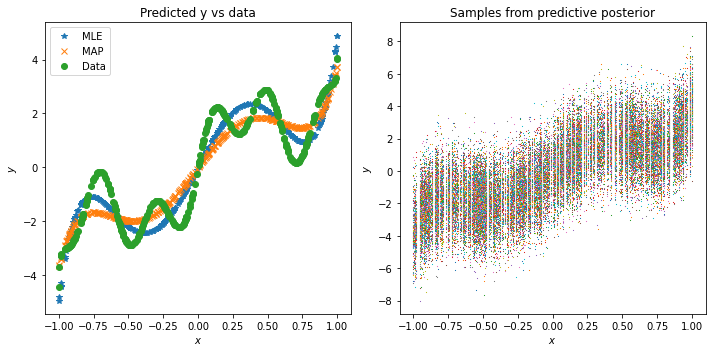

In [125]:
# Fit MLE and MAP estimates for w
w_MLE = model.fit_MLE_mono()
w_MAP, Lambda_inv = model.fit_MAP_mono()

# Draw samples from the predictive posterior
num_samples = 100
mean_star, var_star = model.predictive_distribution_mono()
samples = random.multivariate_normal(key, mean_star.flatten(), var_star, (num_samples,))

# Plot predicted y vs data
y_pred_MLE = np.matmul(np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose(), w_MLE)
y_pred_MAP = np.matmul(np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose(), w_MAP)
plt.figure(1, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(X, y_pred_MLE, "*", label = 'MLE')
plt.plot(X, y_pred_MAP, "x", label = 'MAP')
plt.plot()
plt.plot(X,y,'o', label = 'Data')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Predicted y vs data")

# Plot samples from predictive posterior
plt.subplot(1, 2, 2)
plt.plot(X, samples.T, "x", markersize=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Samples from predictive posterior")

plt.tight_layout()
plt.show()

## Fourier basis

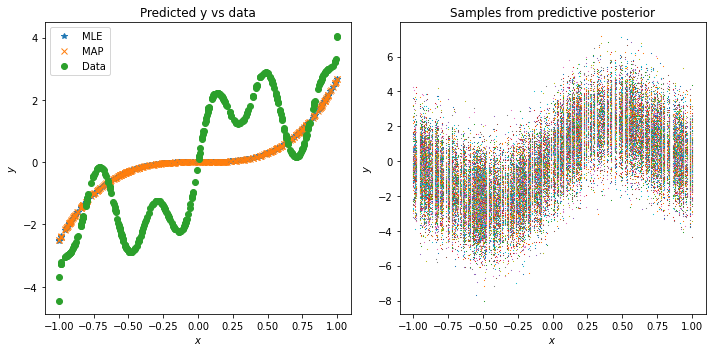

In [ ]:
# Fit MLE and MAP estimates for w
w_MLE = model.fit_MLE_four()
w_MAP, Lambda_inv = model.fit_MAP_four()

# Draw samples from the predictive posterior
num_samples = 100
mean_star, var_star = model.predictive_distribution_four()
samples = random.multivariate_normal(key, mean_star.flatten(), var_star, (num_samples,))

# Plot predicted y vs data
y_pred_MLE = np.matmul(np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose(), w_MLE)
y_pred_MAP = np.matmul(np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose(), w_MAP)
plt.figure(1, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(X, y_pred_MLE, "*", label = 'MLE')
plt.plot(X, y_pred_MAP, "x", label = 'MAP')
plt.plot()
plt.plot(X,y,'o', label = 'Data')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Predicted y vs data")

# Plot samples from predictive posterior
plt.subplot(1, 2, 2)
plt.plot(X, samples.T, "x", markersize=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Samples from predictive posterior")

plt.tight_layout()
plt.show()

## Legendre basis

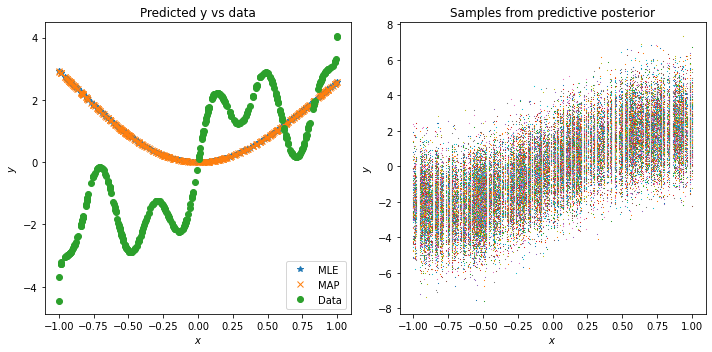

In [126]:
# Fit MLE and MAP estimates for w
w_MLE = model.fit_MLE_lege()
w_MAP, Lambda_inv = model.fit_MAP_lege()

# Draw samples from the predictive posterior
num_samples = 100
mean_star, var_star = model.predictive_distribution_lege()
samples = random.multivariate_normal(key, mean_star.flatten(), var_star, (num_samples,))

# Plot predicted y vs data
y_pred_MLE = np.matmul(np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose(), w_MLE)
y_pred_MAP = np.matmul(np.vstack((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5))).transpose(), w_MAP)
plt.figure(1, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(X, y_pred_MLE, "*", label = 'MLE')
plt.plot(X, y_pred_MAP, "x", label = 'MAP')
plt.plot()
plt.plot(X,y,'o', label = 'Data')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Predicted y vs data")

# Plot samples from predictive posterior
plt.subplot(1, 2, 2)
plt.plot(X, samples.T, "x", markersize=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Samples from predictive posterior")

plt.tight_layout()
plt.show()

It seems to be that the monomial basis works the best for this function. This is likely becausefor the case $M=5$, this basis seems to be the most conducive to universal approximation because its basis extends to $x^4$, allowing it to be "fine-grained" enough.

I would have expected the Fourier basis to do the best given the original data matches sine and cosine waves, however, it may be that the function was not able to optimally approximate because the basis only extended to $sin(2\pi x)$ and not to anything in the $5\pi x$ range. I was also surprised the Legendre basis performed so poorly, given how potentially expressive its basis seems as well.

## Question 4 [20 Pts]:

Write a logistic regression model to classify the letters from the [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset) letters dataset. Create an 80/20 train/test split of the data. You've been provided a template to carry this out. Fill in the suitable sections of the code.

- First train your model to perform binary classification between the letters b and d. Visualize performance on the training and test sets using a confusion matrix.
- Next, train your model to perform multiclass classification between b, d, p and q. Visualize performance on the training and test sets using a confusion matrix. 

In [ ]:
import torchvision
import jax.numpy as jnp
import jax
import matplotlib.pyplot as pl
import seaborn as sns
from sklearn import metrics

In [ ]:
dataset = torchvision.datasets.EMNIST(root='./', split='letters', train=True, download=True)

In [ ]:
X = jnp.array(dataset.data) # shape: 124800, 28, 28
y = jnp.array(dataset.targets) # shape: 124800 (letters -> 1 to 26)

# Get letter b, d, p and q from the dataset
b_ind = jnp.argwhere(jnp.isin(y, 2)).ravel()
d_ind = jnp.argwhere(jnp.isin(y, 4)).ravel()
p_ind = jnp.argwhere(jnp.isin(y, 16)).ravel()
q_ind = jnp.argwhere(jnp.isin(y, 17)).ravel()

# Combine them below to create datasets for usage in following parts:

# create X_bd, Y_bd for binary classification
X_bd = jnp.concatenate((X[b_ind,:,:], X[d_ind,:,:]))
y_bd = jnp.concatenate((y[b_ind]-2, y[d_ind]-3))

# create X_bdpq, Y_bdpq for multiclass classification
X_bdpq = jnp.concatenate((X[b_ind,:,:], X[d_ind,:,:], X[p_ind,:,:], X[q_ind,:,:]))
y_bdpq = jnp.concatenate((y[b_ind]-2, y[d_ind]-3, y[p_ind]-14, y[q_ind]-14))

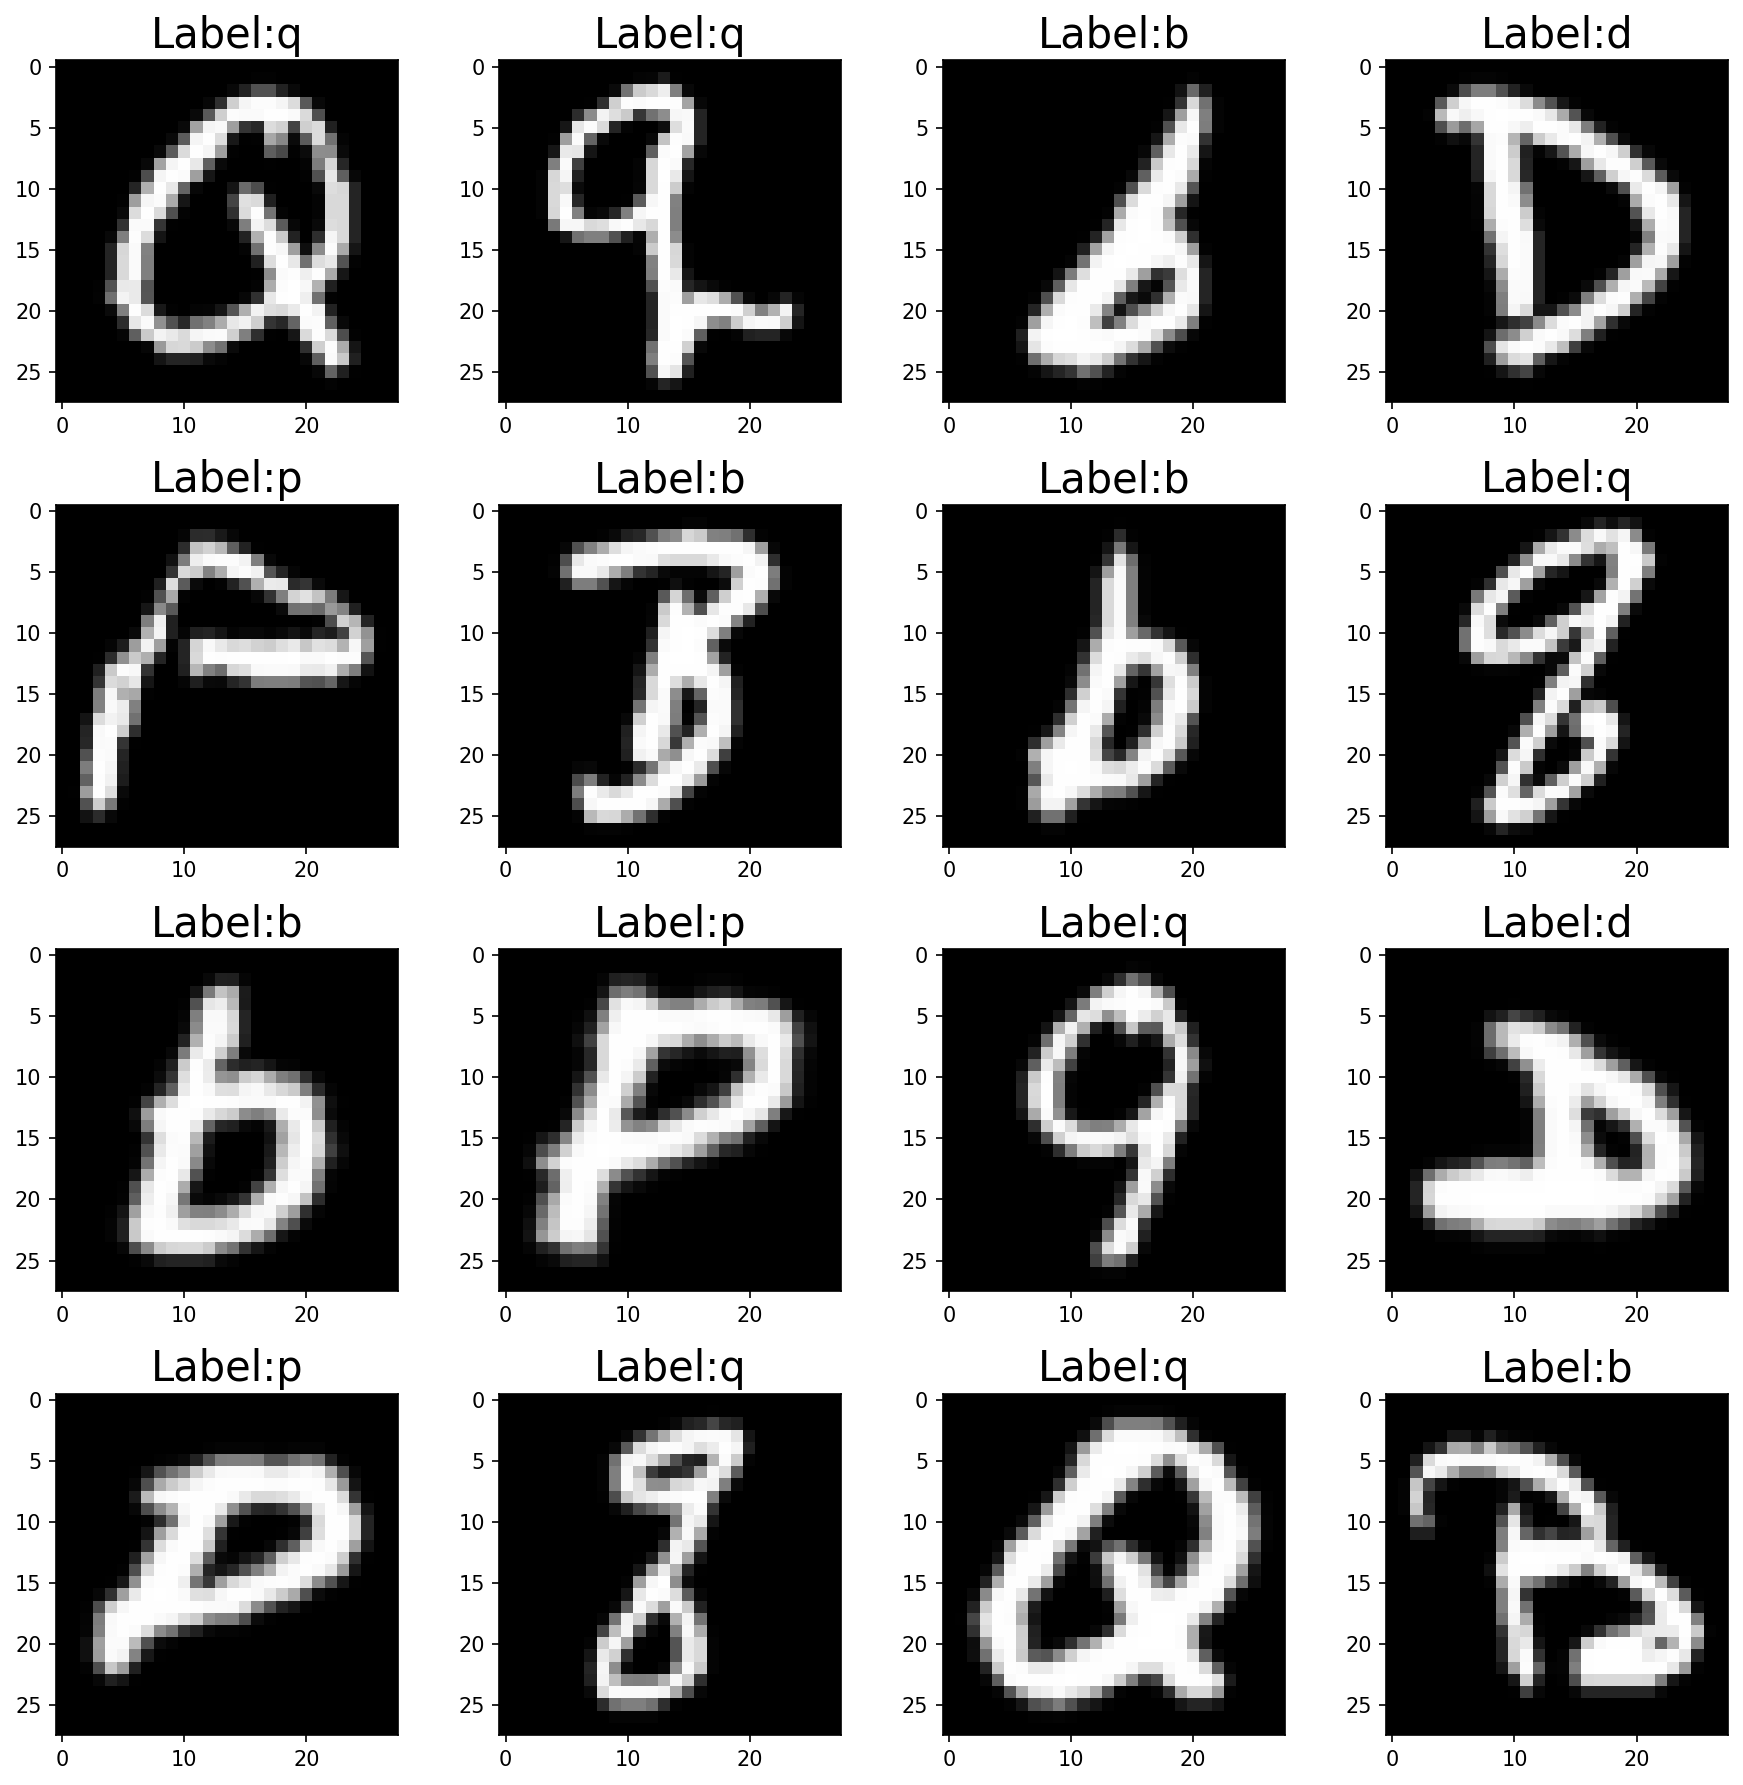

In [ ]:
# Check that the mapping was performed correctly by utilizing a few examples:
# Visualizing that your mapping is performed correctly
rnd_idx = jax.random.randint(jax.random.PRNGKey(42), (16,), 0, X_bdpq.shape[0])
# assuming that the labels are mapped as follows: b -> 0, d -> 1, p -> 2, q -> 3 (change if you're using something different)
str_labels = ['b', 'd', 'p', 'q']
pl.figure(dpi = 150, figsize=(12,12))
for index, (image, label) in enumerate(zip(X_bdpq[rnd_idx], y_bdpq[rnd_idx])):
    pl.subplot(4, 4, index + 1)
    pl.imshow(jnp.reshape(image, (28,28)).T, cmap=pl.cm.gray)
    pl.title('Label:' + str_labels[int(label)], fontsize = 20)
pl.tight_layout()

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bd and y_bd to yield X_train, y_train, X_test, y_test:

key = jax.random.PRNGKey(42)
shuffle = jax.random.permutation(key, X_bd.shape[0])
train = int(.8 * X_bd.shape[0])
test = X_bd.shape[0] - train

X_train = X_bd[shuffle[:train],:,:].reshape(train, 28*28) # shape = (7680, 784)
y_train = y_bd[shuffle[:train]] # shape = (7680,)
X_test = X_bd[shuffle[train:],:,:].reshape(test, 28*28)
y_test = y_bd[shuffle[train:]]

Binary cross-entropy loss formula: $-\frac{1}{n}\sum _{i=1}^n\left(y_i\log \alpha _i+\left(1-y_i\right)\log \left(1-\alpha _i\right)\right)$

In [ ]:
def forward(params, X):
    """
    X: shape (7680, 784)
    params: shape (7680,)
    returns: shape (7680, 1)
    """
    return jax.nn.sigmoid(X @ params)

@jax.jit
def loss_fn(params, X, y):
    """
    X: shape (7680, 784)
    params: shape (7680,)
    """
    # fill this in to compute and return the binary cross entropy loss
    y_hat = forward(params, X).squeeze() # shape (7480,)
    loss_wo_sum = (y * jnp.log(y_hat)) + ((1-y)*jnp.log(1-y_hat)) # shape (7480,)
    loss = -1 * jnp.mean(loss_wo_sum) # shape ()
    return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

# QUESTION: DOES DOING SQUEEZE MESS WITH THE GRADIENT CALCULATION??

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 1])

# Gradient descent
# Learning Rate
alpha = 5e-7
n_its = 5000

loss_history = [loss_fn(params, X_train, y_train)]
for i in range(n_its):
    g      = grad_loss(params, X_train, y_train)
    params = jax.tree_map(lambda x, g: x - alpha * g, params, g)

    # Track progress:
    loss_history = loss_history + [loss_fn(params, X_train, y_train)]

Text(0.5, 0, 'Number of Iterations')

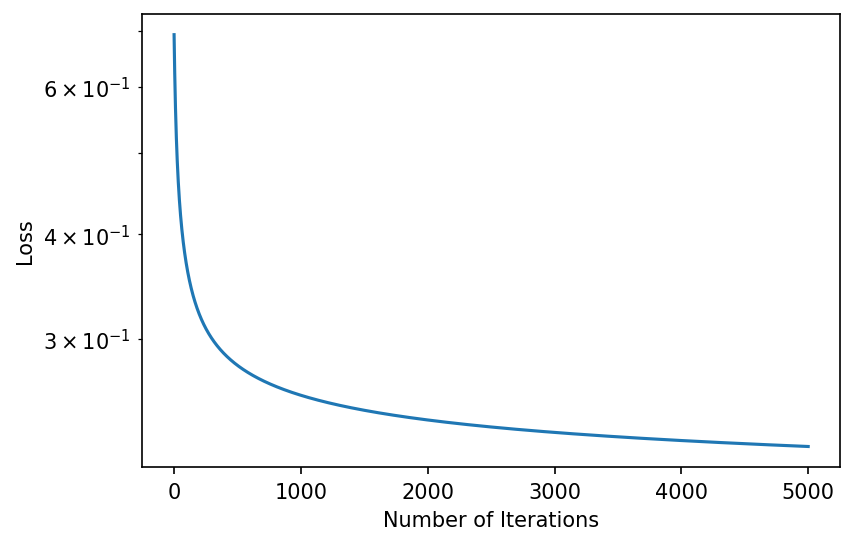

In [ ]:
# Plotting the loss history
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.round(forward(params, X_test)).ravel() == y_test).mean()
cm             = metrics.confusion_matrix(y_test, jnp.round(forward(params, X_test)))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]

print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.9125


Text(0.5, 1.0, 'Confusion Matrix')

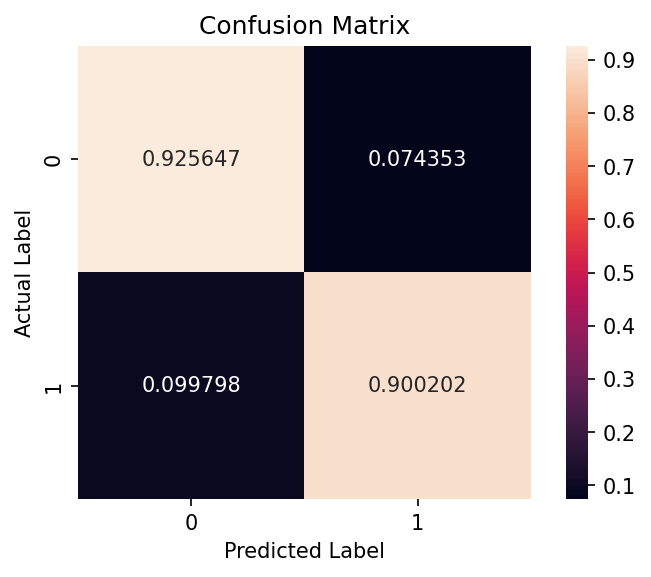

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bdpq and y_bdpq to yield X_train, y_train, X_test, y_test:

# Remember that you need to be one hot encoding the labels for multiclass classification
"""
From 1->b, 2->d, 3->p, 4->q to:
[1 0 0 0] -> b
[0 1 0 0] -> d
[0 0 1 0] -> p
[0 0 0 1] -> q
"""

shuffle = jax.random.permutation(key, X_bdpq.shape[0])
train = int(.8 * X_bdpq.shape[0])
test = X_bdpq.shape[0] - train

X_train = X_bdpq[shuffle[:train],:,:].reshape(train, 28*28)
y_train = jax.nn.one_hot(y_bdpq[shuffle[:train]], 4)
X_test = X_bdpq[shuffle[train:],:,:].reshape(test, 28*28)
y_test = jax.nn.one_hot(y_bdpq[shuffle[train:]], 4)

In [ ]:
def forward(params, X):
    return jax.nn.softmax(X @ params)

@jax.jit
def loss_fn(params, X, y):
    # fill this in to compute and return the binary cross entropy loss
    y_hat = forward(params, X).squeeze() # shape (15360, 784)
    loss_wo_sum = (y * jnp.log(y_hat)) + ((1-y)*jnp.log(1-y_hat)) # shape (15360, 784)
    loss = -1 * jnp.mean(loss_wo_sum) # shape ()
    return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 4])

# Gradient descent
# Learning Rate
alpha = 6e-7
n_its = 5000

loss_history = [loss_fn(params, X_train, y_train)]
for i in range(n_its):
    g      = grad_loss(params, X_train, y_train)
    params = jax.tree_map(lambda x, g: x - alpha * g, params, g)

    # Track progress:
    loss_history = loss_history + [loss_fn(params, X_train, y_train)]

Text(0.5, 0, 'Number of Iterations')

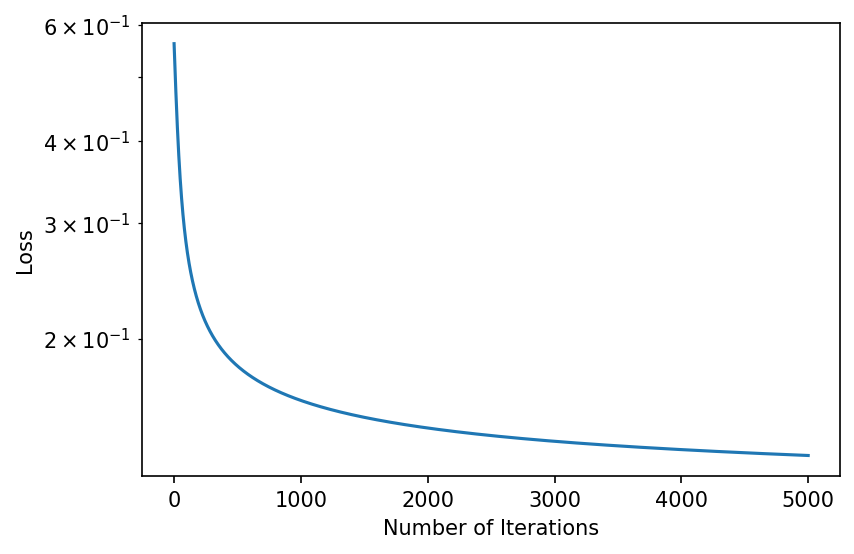

In [ ]:
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.argmax(forward(params, X_test), axis = 1) == 
                  jnp.argmax(y_test, axis = 1)).mean()
cm             = metrics.confusion_matrix(jnp.argmax(y_test, axis = 1), 
                                          jnp.argmax(forward(params, X_test), axis = 1))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]
print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.9044271


Text(0.5, 1.0, 'Confusion Matrix')

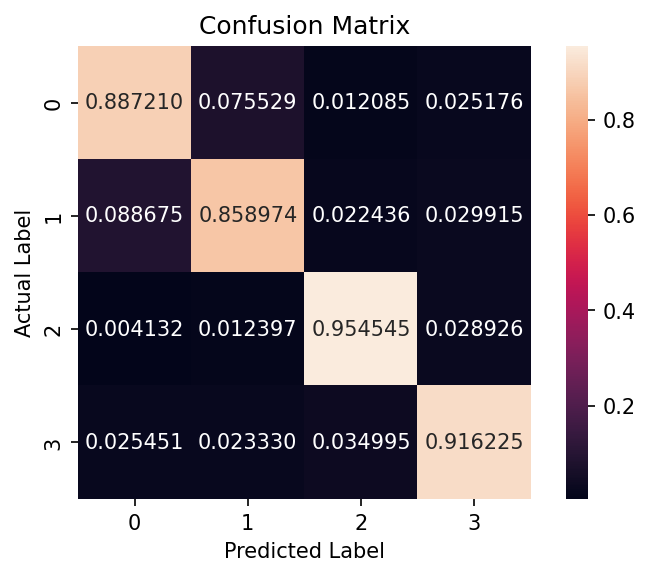

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

## Question 5 [20 Pts]:
Write Python routines:
- `gradient_descent(f, g, x0, eta)` that performs an iteration of gradient descent on a given function $f(x)$ and its gradient $g(x)$, starting at a given point $x_0$, and using a given step-size $\eta$.
- `newton(f, g, H, x0, eta)` that performs an iteration of Newton's method on a given function $f(x)$, its gradient $g(x)$ and Hessian $H(x)$, starting at a given point $x_0$, and using a given step-size $\eta$.

Do **NOT** use `jax.grad` or `jax.hessian` (you need to define the gradient and Hessian functions). Use those routines in an optimization loop to optimize the following two functions:

- $$f_1(x, y) = x^2 + 100 y^2 $$
- $$f_2(x, y) = (1 - x)^2 + 100(y - x^2)^2,$$

Consider step-sizes $\eta = 0.001, 0.01, 1$. Take your initial starting location as $(-1, 1)$. Comment on the following: 
- What is the effect of step-size on the different problems, and algorithms? 
- When the algorithm does converge, how many steps does it take to reach the minimum?

Give suitable reasons for your observations. Plot the objective function value vs the iterate number, and a plot that shows the progress on a contour plot of the landscape. Use these to support your reasoning.

In [132]:
import jax.numpy as np   
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_map

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [156]:
# Define function that performs one iteration for gradient descent

@jax.jit
def gradient_descent(f, g, x0, eta):
  return x0 - eta * g

@jax.jit
def newton(f, g, H, x0, eta):
  return x0 - eta * np.matmul(np.linalg.inv(H),g)

In [157]:
# Define f1, gradient, Hessian
f1 = lambda x,y: np.power(x,2) + 100*np.power(y,2) # minimize this
g1_x = lambda x: 2 * x
g1_y = lambda y: 200 * y
H1_xx = lambda x: 2
H1_xy = lambda x,y: 0
H1_yy = lambda y: 200

# Define f2, gradient, Hessian
f2 = lambda x,y: np.power(1-x,2) + 100*np.power(y-np.power(x,2),2) # minimize this
g2_x = lambda x: 2*x - 2 + -400*y*x + 400*np.power(x,3)
g2_y = lambda y: 200 * y - 200 * np.power(x, 2)
H2_xx = lambda x: 2 - 400 * (y - 3 * np.power(x, 2))
H2_xy = lambda x,y: -400 * x
H2_yy = lambda y: 200

n_iter = 1000

In [158]:
# Define function to make it easy to call iterative descent
def iterative_descent(func, gx, gy, hxx, hxy, hyy, stepsize, title, gradescent = True):
  x = -1
  y = 1
  loss_history = []
  x_history = []
  y_history = []

  eta = stepsize

  for i in range(n_iter):
    g = np.array([gx(x), gy(y)])
    H = np.array([[hxx(x), hxy(x, y)],
                [hxy(x, y), hyy(y)]])
    f = func(x,y)
    x0 = np.array([x, y])
    if gradescent:
      update = gradient_descent(f, g, x0, eta)
    else:
      update = newton(f, g, H, x0, eta)

    # print(f"iteration: {i}       function: {f}      x: {x}    y: {y}")
    loss_history.append(f)
    x_history.append(x)
    y_history.append(y)

    x = update[0]
    y = update[1]

    # Show progress
    if i % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(5, 5))
        X, Y = np.meshgrid(np.arange(-5.0, 5.0, 0.05), np.arange(-5.0, 5.0, 0.05))
        Z = func(X, Y)
        CS = plt.contour(X, Y, Z)
        pl.title(title)
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.plot(x, y, "o", color = 'black')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
        print(f"iteration = {i}, loss = {f}, x = {x}, y = {y}")

  # Plotting the loss history
  pl.figure(figsize = (7, 4))
  pl.semilogy(loss_history)
  pl.ylabel('Loss')
  pl.xlabel('Number of Iterations')

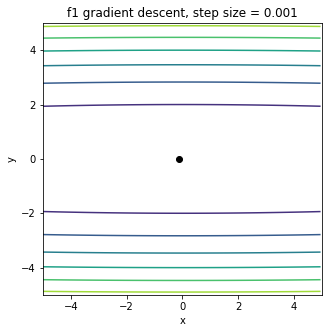

iteration = 990, loss = 0.018987659364938736, x = -0.13752011954784393, y = 0.0


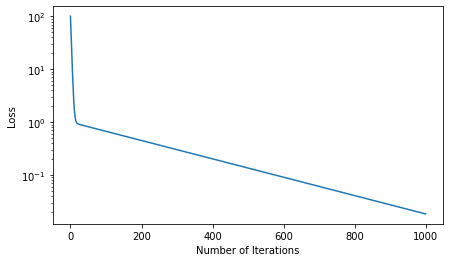

In [154]:
iterative_descent(f1, g1_x, g1_y, H1_xx, H1_xy, H1_yy, 0.001, "f1 gradient descent, step size = 0.001", True)

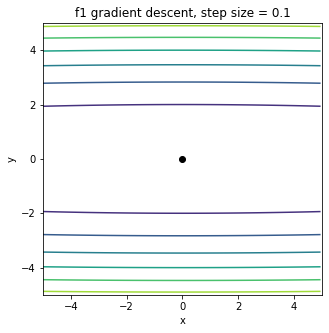

iteration = 990, loss = 0.0, x = -0.0, y = 0.0


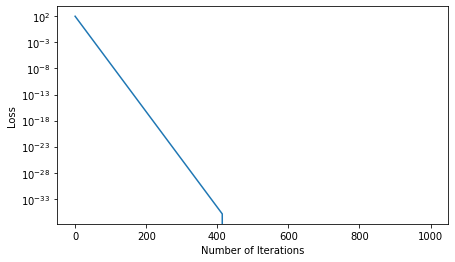

In [160]:
iterative_descent(f1, g1_x, g1_y, H1_xx, H1_xy, H1_yy, 0.1, "f1 gradient descent, step size = 0.1", False)

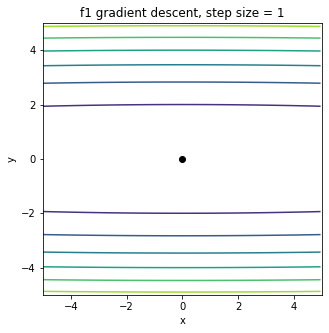

iteration = 990, loss = 0.0, x = 0.0, y = 0.0


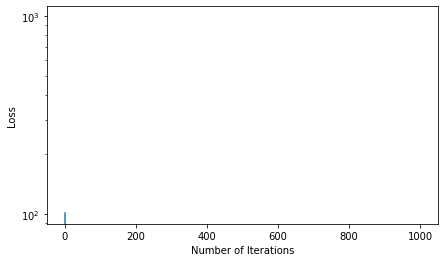

In [163]:
iterative_descent(f1, g1_x, g1_y, H1_xx, H1_xy, H1_yy, 1, "f1 gradient descent, step size = 1", False)

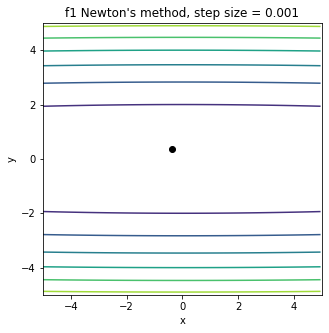

iteration = 990, loss = 13.93118667602539, x = -0.3710213005542755, y = 0.3710213005542755


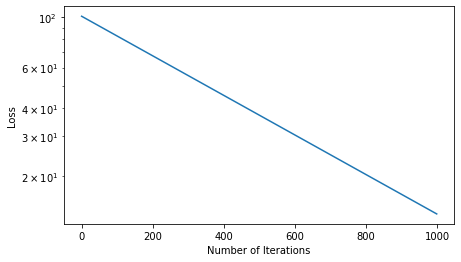

In [159]:
iterative_descent(f1, g1_x, g1_y, H1_xx, H1_xy, H1_yy, 0.001, "f1 Newton's method, step size = 0.001", False)

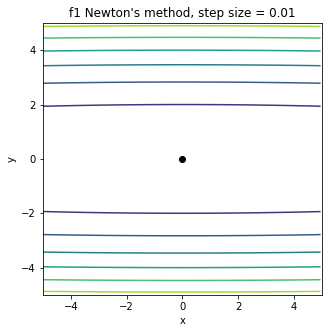

iteration = 990, loss = 2.301481032418451e-07, x = -4.725828694063239e-05, y = 4.725831240648404e-05


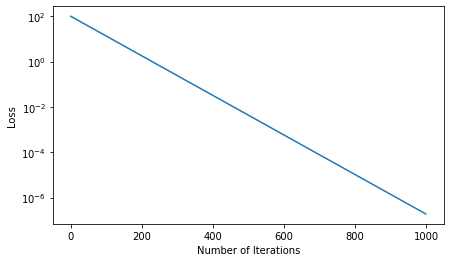

In [164]:
iterative_descent(f1, g1_x, g1_y, H1_xx, H1_xy, H1_yy, 0.01, "f1 Newton's method, step size = 0.01", False)

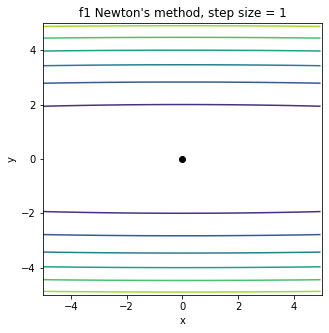

iteration = 990, loss = 0.0, x = 0.0, y = 0.0


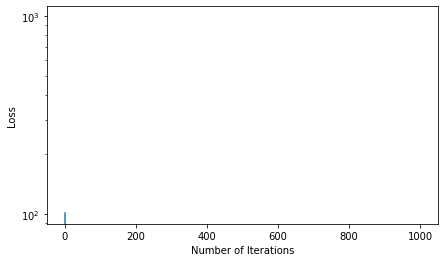

In [165]:
iterative_descent(f1, g1_x, g1_y, H1_xx, H1_xy, H1_yy, 1, "f1 Newton's method, step size = 1", False)